In [1]:
import os
import gym
from _base import build_env, experiment_dir
import _top_level
from _top_level import top_level
top_level()

In [2]:
from src.agents import DeepQAgent
from src.utils import BaseCallback
from src.utils import seed

Using TensorFlow backend.


In [3]:
# set the random number seed
seed(1)
# make the output directory 
OUTPUT_DIR = experiment_dir('../results', 'SuperMarioBros-4-4-v0', DeepQAgent.__name__)
# create a file to save the weights to
WEIGHTS_FILE = '{}/weights.h5'.format(OUTPUT_DIR)

In [4]:
# create an agent
agent = DeepQAgent(build_env('SuperMarioBros-4-4-v0'), render_mode='human')

In [5]:
agent.observe(replay_start_size=100)

158frame [00:01, 104.42frame/s]                    


In [6]:
# create a callback for the training procedure
callback = BaseCallback(WEIGHTS_FILE)
# train the agent with given parameters and the callback
agent.train(frames_to_play=500, callback=callback)
# save the weights to disk after the training procedure
agent.model.save_weights(WEIGHTS_FILE, overwrite=True)

679frame [00:07, 96.45frame/s, loss=45.9, score=1.8e+03]                      


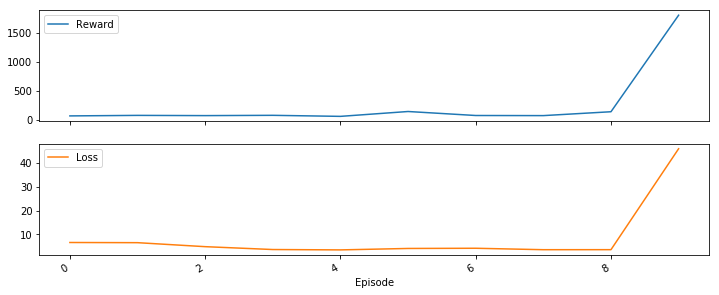

In [7]:
callback.export('{}/training'.format(OUTPUT_DIR))

In [8]:
# if monitoring is enabled, setup the monitor for the environment
agent.env = gym.wrappers.Monitor(agent.env, os.path.join(OUTPUT_DIR, 'monitor'), force=True)

In [9]:
df = agent.play(games=100, exploration_rate=0.05)

100%|██████████| 100/100 [00:21<00:00,  5.32game/s, score=75]     


In [10]:
df.head()

,Score
Episode,
0,887.0
1,64.0
2,74.0
3,70.0
4,76.0


In [11]:
df.tail()

,Score
Episode,
106,77.0
107,75.0
108,75.0
109,138.0
110,75.0


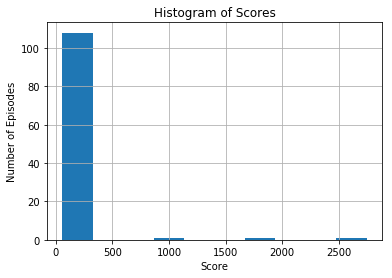

In [12]:
agent.plot_episode_rewards(os.path.join(OUTPUT_DIR, 'episode_rewards'))